# Analyze an image with Computer Vision API using Python

#### With the Analyze Image method, you can extract visual features based on image content. You can upload an image or specify an image URL and choose which features to return, including:

- A detailed list of tags related to the image content.
- A description of image content in a complete sentence.
- The coordinates, gender, and age of any faces contained in the image.
- The ImageType (clip art or a line drawing).
- The dominant color, the accent color, or whether an image is black & white.
- The category defined in this taxonomy.
- Does the image contain adult or sexually suggestive content?
- Analyze an image




To use the Computer Vision API, you need a subscription key. You can get free subscription keys [here](https://docs.microsoft.com/azure/cognitive-services/Computer-vision/Vision-API-How-to-Topics/HowToSubscribe).

To begin analyzing images, replace subscription_key with a valid API key that you obtained earlier.

In [1]:
subscription_key = "58fcc35e151d43ce870da2df2923e701"
assert subscription_key

Next, ensure that region assigned to the **vision_base_url** variable corresponds to the correct endpoint for your API key (westus, westcentralus, etc.). You can find the correct endpoint in the Azure Portal under the QuickStart panel for the service you created.

In [2]:
vision_base_url = "https://uksouth.api.cognitive.microsoft.com/vision/v1.0/"

Next build the full API call, by appending the command you wish to use to the vision_base_url variable.

The image analysis URL looks like the following [(see REST API docs here)](https://westcentralus.dev.cognitive.microsoft.com/docs/services/5adf991815e1060e6355ad44/operations/56f91f2e778daf14a499e1fa).

https://[location].api.cognitive.microsoft.com/vision/v2.0/analyze[?visualFeatures][&details][&language]

In [3]:
vision_analyze_url = vision_base_url + "analyze"

To begin analyzing an image, set image_url to the URL of any image that you want to analyze.

In [15]:
image_url = "https://raw.githubusercontent.com/christinaleo-msft/S2DS/master/Demo%20Images/dragonboating_1.jpg"

The following block uses the requests library in Python to call out to the Computer Vision analyze API and return the results as a JSON object. The API key is passed in via the headers dictionary and the types of features to recognize via the params dictionary. To see the full list of options that can be used, refer to the REST API documentation for image analysis.

In [16]:
import requests
headers  = {'Ocp-Apim-Subscription-Key': subscription_key }
params   = {'visualFeatures': 'Categories,Description,Color'}
data     = {'url': image_url}
response = requests.post(vision_analyze_url, headers=headers, params=params, json=data)
response.raise_for_status()
analysis = response.json()

The `analysis` object contains various fields that describe the image. The most relevant caption for the image can be obtained from the `descriptions` property.

In [18]:
print(analysis)

{'categories': [{'name': 'outdoor_', 'score': 0.546875, 'detail': {'landmarks': []}}], 'description': {'tags': ['water', 'outdoor', 'boat', 'riding', 'child', 'river', 'small', 'group', 'row', 'man', 'rowing', 'long', 'people', 'dog', 'young', 'lake', 'little', 'large', 'red', 'boy', 'body', 'team', 'skiing', 'board', 'hot', 'woman', 'ocean', 'motorcycle', 'traveling', 'standing', 'playing', 'jet'], 'captions': [{'text': 'a group of people rowing a boat in the water', 'confidence': 0.976199697665354}]}, 'color': {'dominantColorForeground': 'White', 'dominantColorBackground': 'Grey', 'dominantColors': ['Grey', 'White'], 'accentColor': '75312F', 'isBwImg': False}, 'requestId': '2cfe0ffc-be8b-42ac-bb10-b08fa29c3b3e', 'metadata': {'height': 1368, 'width': 912, 'format': 'Jpeg'}}


In [19]:
image_caption = analysis["description"]["captions"][0]["text"].capitalize()
print(image_caption)

A group of people rowing a boat in the water


The following lines of code display the image and overlay it with the inferred caption.

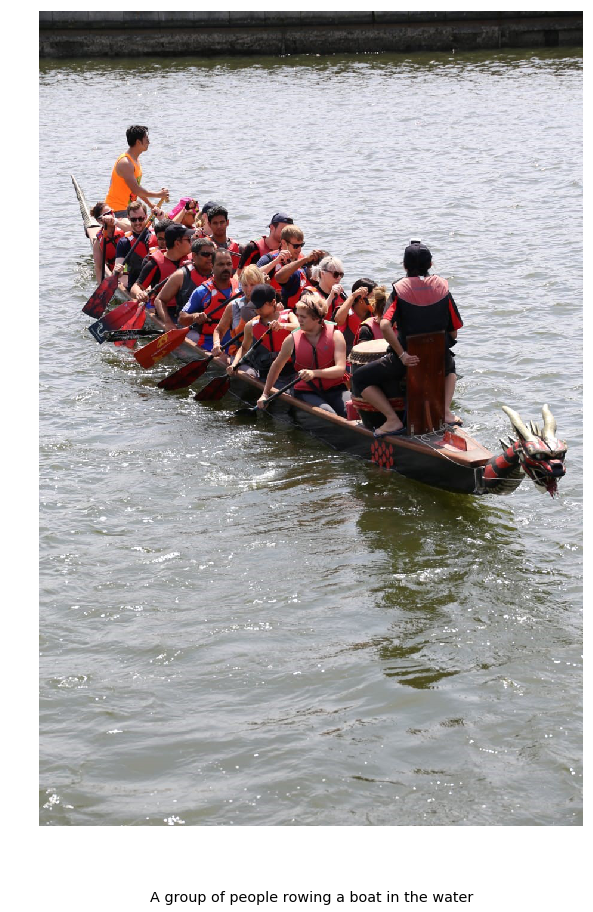

In [21]:
%matplotlib inline
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)
plt.axis("off")
_ = plt.title(image_caption, size="x-large", y=-0.1)




## -------------------------------------------------------------------------------------------------












## Text recognition with Computer Vision API 
Use the [Recognize Text method](https://westcentralus.dev.cognitive.microsoft.com/docs/services/5adf991815e1060e6355ad44/operations/587f2c6a154055056008f200) to asynchronously detect handwritten or printed text in an image and extract recognized characters into a machine-usable character stream.

Set image_url to point to the image to be recognized.

In [8]:
image_url = "https://raw.githubusercontent.com/christinaleo-msft/S2DS/master/Demo%20Images/handwriting.JPG"

The service endpoint for the text recognition service can be constructed as follows:

In [9]:
text_recognition_url = vision_base_url + "recognizeText"
print(text_recognition_url)

https://uksouth.api.cognitive.microsoft.com/vision/v1.0/recognizeText


The handwritten text recognition service can be used to recognize the text in the image. In the `params` dictionary, you can set `mode` to `Printed` to recognize only printed text.

In [10]:
headers  = {'Ocp-Apim-Subscription-Key': subscription_key}
params   = {'mode' : 'Handwritten'}
data     = {'url': image_url}
response = requests.post(text_recognition_url, headers=headers, params=params, json=data)
response.raise_for_status()

The text recognition service does not return the recognized text by itself. Instead, it returns immediately with an "Operation Location" URL in the response header that must be polled to get the result of the operation.

In [11]:
operation_url = response.headers["Operation-Location"]

After obtaining the `operation_url`, you can query it for the analyzed text. The following lines of code implement a polling loop in order to wait for the operation to complete. Notice that the polling is done via an HTTP `GET` method instead of `POST`.

In [12]:
import time

analysis = {}
while not "recognitionResult" in analysis:
    response_final = requests.get(response.headers["Operation-Location"], headers=headers)
    analysis       = response_final.json()
    time.sleep(1)

Next, the recognized text along with the bounding boxes can be extracted as shown in the following line of code. An important point to note is that the handwritten text recognition API returns bounding boxes as **polygons** instead of **rectangles**. Each polygon is p is defined by its vertices specified using the following convention:

p = [x1, y1, x2, y2, ..., xN, yN]

In [13]:
polygons = [(line["boundingBox"], line["text"]) for line in analysis["recognitionResult"]["lines"]]

Finally, the recognized text can be overlaid on top of the original image using the extracted polygon information. Notice that `matplotlib` requires the vertices to be specified as a list of tuples of the form:

p = [(x1, y1), (x2, y2), ..., (xN, yN)]

and the post-processing code transforms the polygon data returned by the service into the form required by `matplotlib`.

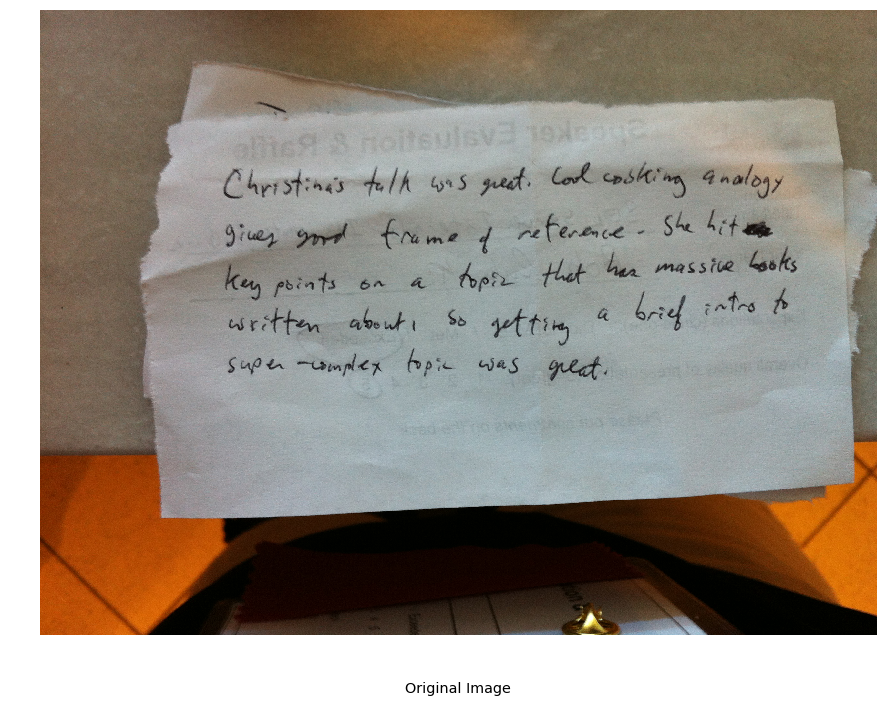

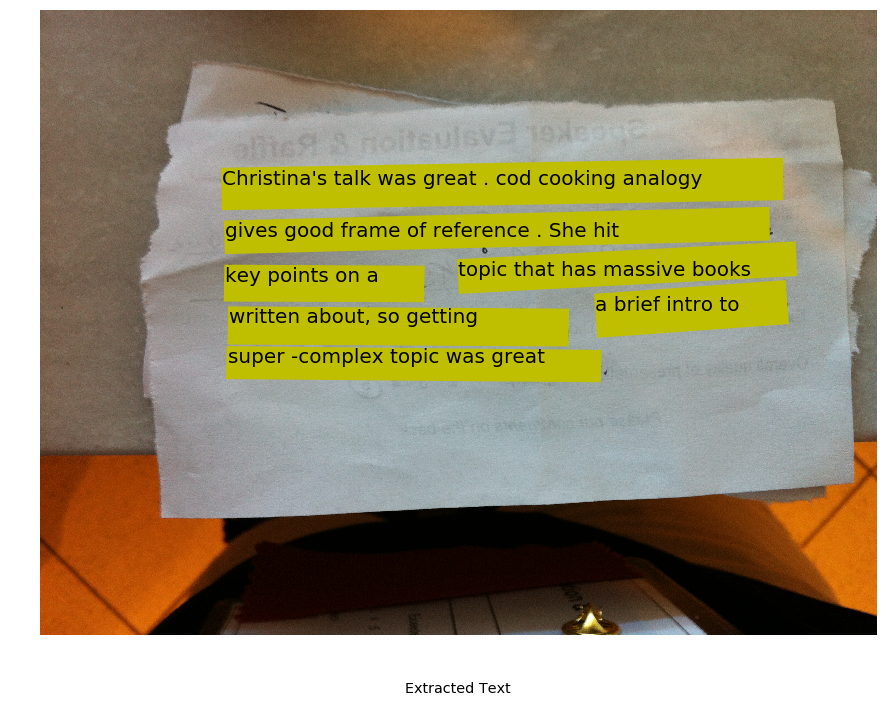

In [14]:
%matplotlib inline
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)
plt.axis("off")
_ = plt.title("Original Image", size="x-large", y=-0.1)


from matplotlib.patches import Polygon

plt.figure(figsize=(15,15))

image  = Image.open(BytesIO(requests.get(image_url).content))
ax     = plt.imshow(image)
for polygon in polygons:
    vertices = [(polygon[0][i], polygon[0][i+1]) for i in range(0,len(polygon[0]),2)]
    text     = polygon[1]
    patch    = Polygon(vertices, closed=True,fill=True, linewidth=2, color='y')
    ax.axes.add_patch(patch)
    plt.text(vertices[0][0], vertices[0][1], text, fontsize=20, va="top")
_ = plt.axis("off")
_ = plt.title("Extracted Text", size="x-large", y=-0.1)